In [10]:
from ase.units import kB, Ha
print(Ha)

27.211386024367243


<>:201: SyntaxWarning: invalid escape sequence '\D'
<>:201: SyntaxWarning: invalid escape sequence '\D'
C:\Users\zayah\AppData\Local\Temp\ipykernel_15412\1913838308.py:201: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$G (eV)',fontsize=20)


-59849.7720727733


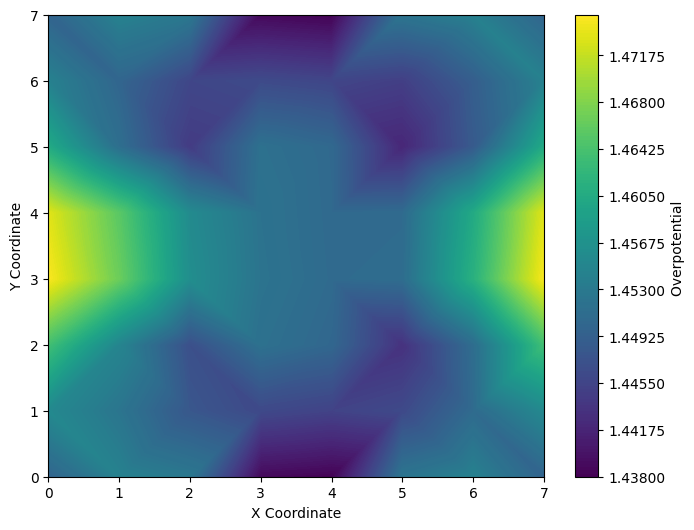

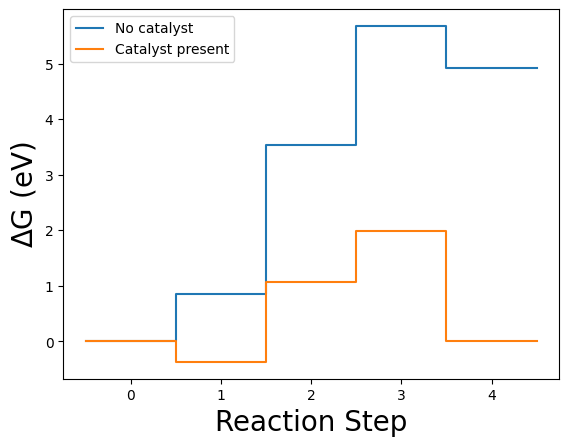

,O,OH,OOH,Overpotential
0,-60413.217101,-60431.704296,-60993.876054,1.449774
1,-60413.317369,-60431.810174,-60993.929912,1.455383
2,-60413.421360,-60431.922511,-60993.990682,1.463729
3,-60413.364849,-60431.877022,-60993.980326,1.474752
4,-60413.369839,-60431.880534,-60993.982644,1.473274
...,...,...,...,...
59,-60413.366345,-60431.878405,-60993.981121,1.474639
60,-60413.371521,-60431.882104,-60993.983549,1.473162
61,-60413.441808,-60431.939518,-60994.000020,1.460289
62,-60413.341712,-60431.833210,-60993.941474,1.454076


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase import Atoms
from ase.build import mx2, molecule
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.calculators.espresso import Espresso, EspressoProfile
from ase.optimize import QuasiNewton
import time
from ase.units import kB, Ha
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata



def Overpotential(material_O_csv, material_OH_csv, material_OOH_csv, no_aborbate_material_csv, save_to_csv=False, H2O_molecule=None, H2_molecule=None, material_H_csv=None):

    # Define constants
    eH2O = 0
    eH2 = 0
    eMaterial = 0

    if H2O_molecule is None:
        raise ValueError("This message is to ensure that you would like to use the default H2O molecule SCF energy. If you would like to, please set this value to 0. Otherwise, input your SCF energy for H2O.")
    else:
        eH2O = -44.03688861 * (Ha/2)
    if H2_molecule is None:
        raise ValueError("This message is to ensure that you would like to use the default H2 molecule SCF energy. If you would like to, please set this value to 0. Otherwise, input your SCF energy for H2.")
    else:
        eH2 = -2.33342342 * (Ha/2)

    no_aborbate = pd.read_csv(no_aborbate_material_csv)
    if len(no_aborbate['SCF']) > 1:
        raise ValueError("The CSV file for the material without aborbate has more than one SCF energy. Please ensure that the CSV file only contains one SCF energy.")
    else:
        eMaterial = no_aborbate['SCF'][0] * (Ha/2) # Current .pwi implementation should always trigger this case
        print(eMaterial)

    # Create an empty dataframe with columns O, H, OH, and OOH
    dataframe = pd.DataFrame(columns=['O', 'H', 'OH', 'OOH'])
    
    # Read the CSV files (assuming 'SCF' is a column label, not an index)
    O = pd.read_csv(material_O_csv)[['SCF']]
    # multiply all values by * (Ha/2) to convert from Ha to eV
    O = O * (Ha/2)
    OH = pd.read_csv(material_OH_csv)[['SCF']]
    OH = OH * (Ha/2)
    OOH = pd.read_csv(material_OOH_csv)[['SCF']]
    OOH = OOH * (Ha/2)

    # Create separate dataframes for each element
    O_df = pd.DataFrame({'O': O['SCF']})
    OH_df = pd.DataFrame({'OH': OH['SCF']})
    OOH_df = pd.DataFrame({'OOH': OOH['SCF']})

    scf_df = pd.concat([O_df, OH_df, OOH_df], axis=1)

    op_df = pd.DataFrame(scf_df, columns=['Overpotential'])

    for i in range(len(scf_df)):
        eMaterialO = scf_df['O'][i]
        eMaterialOH = scf_df['OH'][i]
        eMaterialOOH = scf_df['OOH'][i]

        # eMaterial = MoS2.get_potential_energy()
        # eMaterialOH = MoS2OH.get_potential_energy()
        # eMaterialO = MoS2O.get_potential_energy()
        # eMaterialOOH = MoS2OOH.get_potential_energy()
        

        DGtot = 4.92
        zpeH2O = 0.57
        zpeH2 = 0.35

        tdsH2O = 0.67
        tdsH2 = 0.403
        kBT = kB * 298

        zpeMoS2O = 0.06
        zpeMoS2OH = 0.37
        zpeMoS2OOH = 0.44
        zpeMoS2 = 0.

        # 1
        DE1_SHE = eMaterialOH - eH2O - eMaterial + 0.5*eH2
        DZPE1 = zpeMoS2OH - zpeH2O - zpeMoS2 + 0.5*zpeH2
        TDS1 = - tdsH2O + 0.5*tdsH2
        DG1_SHE = DE1_SHE + DZPE1 + TDS1
        # 1

        # 2
        DE2_SHE = eMaterialO - eMaterialOH + 0.5*eH2
        DZPE2 = zpeMoS2O - zpeMoS2OH + 0.5*zpeH2
        TDS2 = 0.5*tdsH2
        DG2_SHE = DE2_SHE + DZPE2 + TDS2
        # 2

        # 3
        DE3_SHE = eMaterialOOH - eMaterialO - eH2O + 0.5*eH2
        DZPE3 = zpeMoS2OOH - zpeMoS2O - zpeH2O + 0.5*zpeH2
        TDS3 = -tdsH2O + 0.5*tdsH2
        DG3_SHE = DE3_SHE + DZPE3 + TDS3
        # 3

        # 4
        DG4_SHE = DGtot - DG1_SHE - DG2_SHE - DG3_SHE
        # 4
        
        # Plot with matplotlib
        steps = np.array([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
        dgs_she = np.array([0,0, DG1_SHE, DG2_SHE, DG3_SHE, DG4_SHE])
        
        pH = 0.
        U = 4.92/4
        DG1_U = DG1_SHE - kBT*np.log(10)*pH - U
        DG2_U = DG2_SHE - kBT*np.log(10)*pH - U
        DG3_U = DG3_SHE - kBT*np.log(10)*pH - U
        DG4_U = DG4_SHE - kBT*np.log(10)*pH - U
            
        steps = np.array([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
        dgs_she = np.array([0,0, DG1_SHE, DG2_SHE, DG3_SHE, DG4_SHE])
        dgs_U = np.array([0,0, DG1_U, DG2_U, DG3_U, DG4_U])
        eta = np.max(dgs_she[2:] - 4.92/4)
        op_df.loc[i] = eta

    final_df = pd.concat([scf_df, op_df], axis=1)

    if save_to_csv:
        final_df.to_csv("overpotential.csv", index=False)

    # plot the lowest point
    def plot_lowest_point(i):
        eMaterialO = scf_df['O'][i]
        eMaterialOH = scf_df['OH'][i]
        eMaterialOOH = scf_df['OOH'][i]

        DGtot = 4.92
        zpeH2O = 0.57
        zpeH2 = 0.35

        tdsH2O = 0.67
        tdsH2 = 0.403
        kBT = kB * 298

        zpeMoS2O = 0.06
        zpeMoS2OH = 0.37
        zpeMoS2OOH = 0.44
        zpeMoS2 = 0.

        # 1
        DE1_SHE = eMaterialOH - eH2O - eMaterial + 0.5*eH2
        DZPE1 = zpeMoS2OH - zpeH2O - zpeMoS2 + 0.5*zpeH2
        TDS1 = - tdsH2O + 0.5*tdsH2
        DG1_SHE = DE1_SHE + DZPE1 + TDS1
        # 1

        # 2
        DE2_SHE = eMaterialO - eMaterialOH + 0.5*eH2
        DZPE2 = zpeMoS2O - zpeMoS2OH + 0.5*zpeH2
        TDS2 = 0.5*tdsH2
        DG2_SHE = DE2_SHE + DZPE2 + TDS2
        # 2

        # 3
        DE3_SHE = eMaterialOOH - eMaterialO - eH2O + 0.5*eH2
        DZPE3 = zpeMoS2OOH - zpeMoS2O - zpeH2O + 0.5*zpeH2
        TDS3 = -tdsH2O + 0.5*tdsH2
        DG3_SHE = DE3_SHE + DZPE3 + TDS3
        # 3

        # 4
        DG4_SHE = DGtot - DG1_SHE - DG2_SHE - DG3_SHE
        # 4
        
        # Plot with matplotlib
        steps = np.array([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
        dgs_she = np.array([0,0, DG1_SHE, DG2_SHE, DG3_SHE, DG4_SHE])
        # plt.step(steps,np.cumsum(dgs_she))
        # plt.xlabel('Reaction Step',fontsize=20)
        # plt.ylabel('$\Delta$G (eV)',fontsize=20)
        # plt.show()
        
        pH = 0.
        U = 4.92/4
        DG1_U = DG1_SHE - kBT*np.log(10)*pH - U
        DG2_U = DG2_SHE - kBT*np.log(10)*pH - U
        DG3_U = DG3_SHE - kBT*np.log(10)*pH - U
        DG4_U = DG4_SHE - kBT*np.log(10)*pH - U
            
        steps = np.array([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
        dgs_she = np.array([0,0, DG1_SHE, DG2_SHE, DG3_SHE, DG4_SHE])
        dgs_U = np.array([0,0, DG1_U, DG2_U, DG3_U, DG4_U])
        plt.step(steps,np.cumsum(dgs_she))
        plt.step(steps,np.cumsum(dgs_U))
        # one of the plots is the reaction steps with the catalyst and the other without. indicate this in the key
        plt.legend(['No catalyst','Catalyst present'])
        plt.xlabel('Reaction Step',fontsize=20)
        plt.ylabel('$\Delta$G (eV)',fontsize=20)
        plt.show()
    
    # create NEW df of just overpotneial and xy
    overpotential_xy = pd.DataFrame(final_df, columns=['X', 'Y', 'Overpotential'])
    lowest_point = overpotential_xy.loc[overpotential_xy['Overpotential'].idxmin()]

    # find the index of the xy of the lowest_point
    lowest_point_index = overpotential_xy.index[overpotential_xy['Overpotential'] == lowest_point['Overpotential']].tolist()[0]

    # Example data setup (assuming you already have this part from your script)
    x = [] 
    y = []
    for i in range(8):
        for j in range(8):
            x.append(i)
            y.append(j)

    # Assuming final_df['Overpotential'] is already computed and available
    overpotential_xy = pd.DataFrame({
        'X': x,
        'Y': y,
        'Overpotential': final_df['Overpotential']  # Make sure final_df['Overpotential'] is aligned with x and y
    })

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.tricontourf(overpotential_xy['X'], overpotential_xy['Y'], overpotential_xy['Overpotential'], levels=150, cmap='viridis')
    plt.colorbar(label='Overpotential ')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.show()

    plot_lowest_point(lowest_point_index)

    return final_df

Overpotential("SrCoO3_A_O_OUT.csv", "SrCoO3_A_OH_OUT.csv", "SrCoO3_A_OOH_OUT.csv", "test_over.csv", True, 0.0, 0.0, "SrCoO3_A_H_OUT.csv")